In [1]:
from sklearn.cluster import DBSCAN 
import easyocr
import numpy as np
from sklearn.preprocessing import StandardScaler

c:\Users\user\anaconda3\envs\computervision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_g(X,labels):
    # plt.figure(figsize=(6, 5))

    unique_labels = np.unique(labels)
    for k in unique_labels:
        mask = (labels == k)
        n = int(mask.sum())
        if k == -1:
            # 노이즈
            plt.scatter(X[mask, 0], X[mask, 1],
                        marker='x', s=30, linewidths=1,
                        label=f'Noise (-1)  n={n}', alpha=0.9)
        else:
            # 각 클러스터별로 따로 그려야 legend에 항목이 생김
            plt.scatter(X[mask, 0], X[mask, 1],
                        s=20, label=f'Cluster {k}  count={n}', alpha=0.5)

    plt.xlabel('width')
    plt.ylabel('height')
    plt.title('Clusters')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show() 
    

In [3]:
import cv2, ctypes
# from processing import get_object_detection_boxes , cluster_boxes
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, HDBSCAN    
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from ultralytics import YOLO
img = r"E:\다운로드\KakaoTalk_20250814_141911336_01.jpg"
imgs = cv2.imread(img)


model = YOLO("weights.pt")



def cluster_boxes(boxes, eps=0.34990236345839165, min_samples=5):
    """
    boxes: List of bounding boxes [x1, y1, x2, y2]
    ocr_texts: OCR 결과 텍스트 리스트
    eps: DBSCAN의 거리 임계값 (같은 행으로 간주할 y축 거리)
    min_samples: 최소 샘플 수 (1로 하면 모든 점 포함 가능)
    
    return: 각 행에 대한 결과 
    """
    if boxes is None or len(boxes) == 0: # 예외처리
        return np.array([]).reshape(0, 1)    
    
    # 박스 하단 y좌표 계산
    X =boxes[:,2:4]
    X_scaler = StandardScaler().fit_transform(X)
    # print(y_centers)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaler)
    # clustering = HDBSCAN(min_cluster_size=2, store_centers = 'centroid' ).fit(X_scaler)
    # clustering = Kmeans
    labels = clustering.labels_  # 각 박스가 속한 행 번호
    # clustering.

    print("클러스터 라벨들:", sorted(set(labels)))
    plot_g(X,labels)    
    return labels.reshape(-1,1)

In [4]:
results = model(img)[0]


image 1/1 E:\\KakaoTalk_20250814_141911336_01.jpg: 640x480 47 book_labels, 163.7ms
Speed: 2.9ms preprocess, 163.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


In [5]:
results.show()

In [ ]:
boxes = get_object_detection_boxes(results)

클러스터 라벨들: [-1, 0, 1, 2]


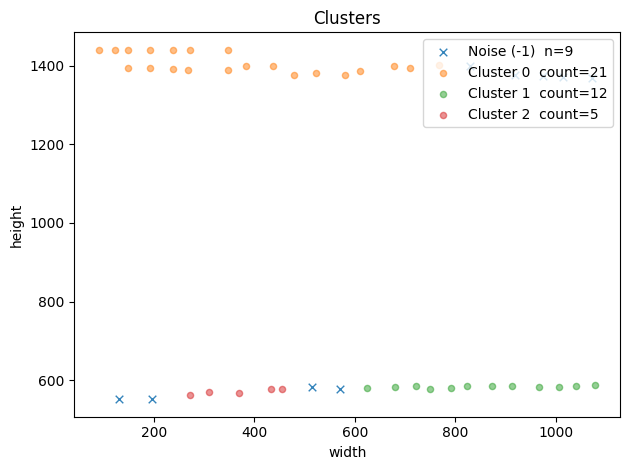

array([[ 0],
       [ 2],
       [-1],
       [ 0],
       [-1],
       [ 0],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 0],
       [-1],
       [ 1],
       [-1],
       [ 0],
       [ 2],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 0],
       [ 1],
       [ 1],
       [ 2],
       [ 0],
       [ 0],
       [ 1],
       [ 1],
       [ 2],
       [ 0],
       [ 1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 0],
       [ 0],
       [-1],
       [ 2],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0]], dtype=int64)

In [ ]:
cluster_boxes(boxes)

In [ ]:
cluster_boxes

<function __main__.cluster_boxes(boxes, eps=0.34990236345839165, min_samples=5)>

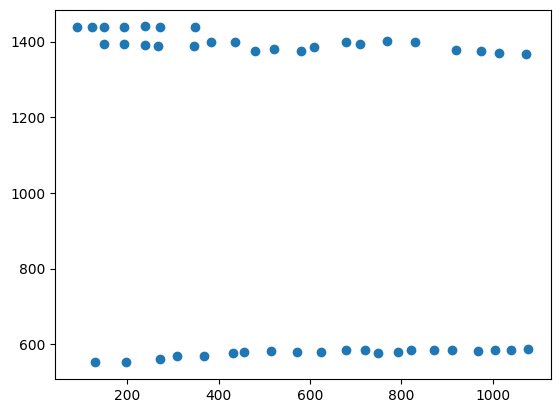

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(boxes[:,2],boxes[:,3])

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def choose_k_and_label(X):  # X: (n,2) [x1,y1]
    Xz = MinMaxScaler().fit_transform(X)
    print(Xz)
    # k=1 inertia
    km1 = KMeans(n_clusters=1, n_init=20, random_state=42).fit(Xz)
    inertia1 = km1.inertia_

    results = {}
    for k in (2, 3):
        km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(Xz)
        labels = km.labels_
        sil = silhouette_score(Xz, labels)
        results[k] = {"model": km, "labels": labels, "sil": sil, "inertia": km.inertia_}

    # 단일 클러스터 여부 점검
    inertia_drop = (inertia1 - results[2]["inertia"]) / max(inertia1, 1e-9)
    if (inertia_drop < 0.10) and (results[2]["sil"] < 0.20) and (results[3]["sil"] < 0.20):
        return 1, km1.labels_

    # k=2 vs k=3 선택 (동점이면 inertia 감소 큰 쪽)
    k_best = max((2,3), key=lambda k: (results[k]["sil"], (inertia1 - results[k]["inertia"])))
    return k_best, results[k_best]["labels"]

# 사용 예:
X = np.concatenate([boxes[:,2].reshape(-1,1),boxes[:,3].reshape(-1,1)],axis= 1)
print(X.shape)
k, labels = choose_k_and_label(X)
print(k)
 

(47, 2)
[[    0.49645      0.9268]
 [    0.18237    0.011261]
 [    0.74772     0.95383]
 [    0.59473      0.9527]
 [    0.83891     0.92905]
 [    0.68592     0.95721]
 [    0.48632    0.030405]
 [    0.59676    0.036036]
 [    0.42857     0.03491]
 [    0.89564     0.92568]
 [    0.99392     0.91892]
 [    0.43668     0.93243]
 [    0.93414      0.9223]
 [    0.79129    0.038288]
 [     0.1074   0.0011261]
 [    0.25937     0.94144]
 [    0.34549    0.028153]
 [    0.88754    0.033784]
 [    0.71023    0.031532]
 [     0.9615    0.038288]
 [    0.54002    0.032658]
 [    0.10334     0.94932]
 [    0.83181    0.038288]
 [    0.92705    0.036036]
 [    0.22188     0.02027]
 [   0.058764     0.99887]
 [    0.35056     0.95383]
 [    0.74063    0.038288]
 [    0.66768    0.028153]
 [    0.28166    0.019144]
 [          0     0.99887]
 [     0.6383    0.037162]
 [    0.26039     0.99887]
 [    0.14894     0.94595]
 [    0.39311      0.9268]
 [    0.29585     0.95383]
 [          1    0.0

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

def _kneedle_eps(dist_sorted):
    """시작-끝 직선과 각 점 사이 최대 거리 지점을 elbow로."""
    x = np.arange(len(dist_sorted))
    x1, y1 = 0, dist_sorted[0]
    x2, y2 = len(dist_sorted)-1, dist_sorted[-1]
    den = np.hypot(x2-x1, y2-y1) + 1e-12
    # 점-직선 거리
    d = np.abs((y2 - y1)*x - (x2 - x1)*dist_sorted + x2*y1 - y2*x1) / den
    idx = int(np.argmax(d))
    return float(dist_sorted[idx])

def _k_distance(Xz, k):
    nn = NearestNeighbors(n_neighbors=k).fit(Xz)
    dists, _ = nn.kneighbors(Xz)
    return np.sort(dists[:, -1])  # 각 점의 k번째 이웃 거리

def auto_dbscan(X, dims=2, min_samples_grid=None, noise_cap=0.5, random_state=42):
    """
    X: (n,d) 데이터
    dims: 차원(D) — 2D면 2
    min_samples_grid: 시도할 min_samples 목록(미지정 시 경험값 사용)
    noise_cap: 노이즈 비율 상한(이보다 크면 후보 탈락)
    반환: best_params, labels
    """
    Xz = StandardScaler().fit_transform(X)
    if min_samples_grid is None:
        # 2D 기준 5~15 권장, 차원 높으면 2D 경험칙
        base = max(dims + 1, 4)
        min_samples_grid = sorted(set([base, 2*dims, 5, 8, 10, 12, 15]))

    best = None
    best_labels = None

    for ms in min_samples_grid:
        kd = _k_distance(Xz, k=ms)
        eps = _kneedle_eps(kd)
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(Xz)

        # 품질 휴리스틱 계산
        mask = labels != -1
        n_noise = np.sum(~mask)
        noise_ratio = n_noise / len(labels)
        n_clusters = len(set(labels[mask]))  # 노이즈 제외
        if n_clusters == 0 or noise_ratio > noise_cap:
            continue

        # 실루엣(노이즈 제외) – 참고용
        try:
            sil = silhouette_score(Xz[mask], labels[mask]) if len(np.unique(labels[mask])) > 1 else -1
        except Exception:
            sil = -1

        score = (sil, -noise_ratio, -abs(n_clusters-3))  # 예: 실루엣↑, 노이즈↓, 클러스터 수는 3에 가깝게(원하면 바꾸세요)
        if (best is None) or (score > best["score"]):
            best = {"eps": eps, "min_samples": ms, "sil": sil,
                    "noise_ratio": noise_ratio, "n_clusters": n_clusters,
                    "score": score}
            best_labels = labels

    if best is None:
        # 보수적으로 min_samples를 크게, eps를 elbow로 재시도
        ms = max(min_samples_grid) + 5
        kd = _k_distance(StandardScaler().fit_transform(X), k=ms)
        eps = _kneedle_eps(kd)
        best = {"eps": eps, "min_samples": ms, "sil": -1, "noise_ratio": 1.0, "n_clusters": 0, "score": (-1,-1,-999)}
        best_labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(StandardScaler().fit_transform(X))

    return best, best_labels

# 사용 예시

best, labels = auto_dbscan(boxes, dims=2)
print(best)  # {'eps': ..., 'min_samples': ..., 'sil': ..., 'noise_ratio': ..., 'n_clusters': ...}


{'eps': 0.5289297388023914, 'min_samples': 5, 'sil': 0.614802576718755, 'noise_ratio': 0.1276595744680851, 'n_clusters': 2, 'score': (0.614802576718755, -0.1276595744680851, -1)}


In [6]:
# ddc_row_detect.py
from __future__ import annotations
from dataclasses import dataclass
from typing import Any, Optional, Dict, Tuple, List
from decimal import Decimal, getcontext
from bisect import bisect_left
import unicodedata, re

getcontext().prec = 50  # DDC 소수부 비교 정밀도

# =========================
#  DDC 키 파싱/비교 유틸
# =========================

JAMO_ORDER = "ㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎ"
JAMO_IDX = {ch: i for i, ch in enumerate(JAMO_ORDER)}

def _to_initial_jamo(ch: str) -> int:
    """완성형 한글을 초성 인덱스(0..18)로 변환."""
    code = ord(ch)
    if 0xAC00 <= code <= 0xD7A3:
        return (code - 0xAC00) // 588
    return JAMO_IDX.get(ch, -1)

def _letter_code(ch: str) -> Tuple[int, int]:
    """문자 정렬 규칙: 영문(A..Z) < 한글(초성순) < 기타."""
    if 'A' <= ch <= 'Z':
        return (0, ord(ch))
    j = _to_initial_jamo(ch)
    if j != -1:
        return (1, j)
    return (2, ord(ch))

def _normalize(s: str) -> str:
    """OCR 후처리: 대문자화, 공백압축, 점/문자 교정 등."""
    s = unicodedata.normalize('NFKC', s.upper())
    s = re.sub(r'\s+', ' ', s).strip()
    s = s.replace('..', '.')
    # 맥락적 OCR 교정
    s = re.sub(r'(?<=\d)O(?=\d)', '0', s)     # O↔0
    s = re.sub(r'(?<=\d)[IL](?=\d)', '1', s)  # I,l↔1
    s = s.replace(',', '.')                   # 004,3 → 004.3
    return s

_TOK = re.compile(r'([A-Z]+|[ㄱ-ㅎ가-힣]+|\d+|[.])')
def _tokens(s: str) -> List[str]:
    return [t for t in _TOK.findall(s) if t]

YEAR = re.compile(r'(?<!\d)((?:19|20)\d{2})(?!\d)')
VOL  = re.compile(r'(?:V|VOL\.?|권)\s*\.?\s*(\d+)', re.I)
PART = re.compile(r'(?:PT|NO)\s*\.?\s*(\d+)', re.I)
COPY = re.compile(r'(?:C|COPY|C\.)\s*\.?\s*(\d+)', re.I)

class DdcKey:
    """DDC 비교용 정규화 키."""
    __slots__ = ("cls", "dec", "cutters", "year", "vol", "part", "copy")
    def __init__(self, cls: int, dec: Decimal,
                 cutters: Tuple[Tuple[int, int, int], ...],
                 year: int, vol: int, part: int, copy: int):
        self.cls = cls
        self.dec = dec
        self.cutters = cutters
        self.year = year
        self.vol = vol
        self.part = part
        self.copy = copy
    def tup(self) -> Tuple:
        # 파이썬 튜플 비교를 활용 (사전식 비교)
        return (self.cls, self.dec, self.cutters, self.year, self.vol, self.part, self.copy)

def parse_ddc_key(raw: str) -> Optional[DdcKey]:
    """DDC 문자열을 DdcKey로 파싱. 실패 시 None."""
    s = _normalize(raw)
    m = re.match(r'^(\d{3})(?:\.(\d+))?', s)  # 004 / 004.3 / 005.133
    if not m:
        return None
    cls = int(m.group(1))
    dec = Decimal('0.' + m.group(2)) if m.group(2) else Decimal(0)
    rest = s[m.end():].strip()

    year = next((int(y) for y in YEAR.findall(rest)), -1)
    vol  = next((int(v) for v in VOL.findall(rest)), -1)
    part = next((int(p) for p in PART.findall(rest)), -1)
    copy = next((int(c) for c in COPY.findall(rest)), -1)

    toks = _tokens(rest)
    cutters: List[Tuple[int, int, int]] = []
    i = 0
    while i < len(toks):
        t = toks[i]
        if t == '.':
            i += 1
            continue
        if re.fullmatch(r'[A-Z]+|[ㄱ-ㅎ가-힣]+', t):
            ch = t[0]
            grp, code = _letter_code(ch)
            num = -1
            if i + 1 < len(toks) and toks[i + 1].isdigit():
                num = int(toks[i + 1])
                i += 1
            cutters.append((grp, code, num))
        i += 1

    return DdcKey(cls, dec, tuple(cutters), year, vol, part, copy)

def _lis_indices(keys: List[DdcKey]) -> set[int]:
    """O(n log n) LIS: 증가 부분수열의 인덱스 집합을 반환."""
    tails: List[int] = []
    prev = [-1] * len(keys)

    def less(i: int, j: int) -> bool:
        return keys[i].tup() < keys[j].tup()

    for i in range(len(keys)):
        lo, hi = 0, len(tails)
        while lo < hi:
            mid = (lo + hi) // 2
            if less(tails[mid], i):
                lo = mid + 1
            else:
                hi = mid
        if lo == len(tails):
            tails.append(i)
        else:
            tails[lo] = i
        if lo > 0:
            prev[i] = tails[lo - 1]

    res = []
    cur = tails[-1] if tails else -1
    while cur != -1:
        res.append(cur)
        cur = prev[cur]
    return set(reversed(res))

def _to_float_or_none(x) -> Optional[float]:
    try:
        return float(x) if x is not None else None
    except Exception:
        return None

# =========================
#   행(row) 단위 탐지 API
# =========================

def detect_row(records: List[Dict[str, Any]],
               conf_threshold_hold: float = 0.70,
               none_conf_as_hold: bool = False) -> Dict[str, Any]:
    """
    같은 행만 담긴 입력을 받아 오배치 탐지.
    입력 레코드 예:
      {'tracker_id': 1, 'xyxy': [x1,y1,x2,y2], 'ocr': '004.3 P1', 'ocr_conf': 0.95, 'row': 0}

    반환:
      {
        "ordered": [tracker_id...],             # 좌->우 정렬된 ID
        "lis_indices": {int,...},               # 정상(LIS) 인덱스(좌->우 기준)
        "misplaced": [ {i, tracker_id, ocr, reason, move{to_index,delta,hint}} ... ],
        "hold":      [ {i, tracker_id, reason} ... ]
      }
    """
    # 1) 좌->우 정렬(x1 기준)
    seq = sorted(records, key=lambda r: float(r['xyxy'][0]))
    ordered_ids = [r['tracker_id'] for r in seq]

    # 2) 파싱 + 신뢰도
    keys: List[Optional[DdcKey]] = []
    hold: List[Dict[str, Any]] = []
    valid_idx: List[int] = []

    for i, r in enumerate(seq):
        conf = _to_float_or_none(r.get('ocr_conf', None))
        key = parse_ddc_key(str(r.get('ocr', '')))
        keys.append(key)

        if key is None:
            hold.append({"i": i, "tracker_id": r['tracker_id'], "reason": "DDC 파싱 실패"})
        elif (conf is None) and none_conf_as_hold:
            hold.append({"i": i, "tracker_id": r['tracker_id'], "reason": "OCR 신뢰도 없음(None)"})
        elif (conf is not None) and (conf < conf_threshold_hold):
            hold.append({"i": i, "tracker_id": r['tracker_id'], "reason": f"OCR 신뢰도 낮음({conf:.2f})"})
        else:
            valid_idx.append(i)

    # 3) 유효 항목으로 LIS → 확정 오배치
    lis_set: set[int] = set()
    misplaced: List[Dict[str, Any]] = []
    
    if valid_idx:
        sub = [keys[i] for i in valid_idx]  # type: ignore
        lis_sub = _lis_indices(sub)
        lis_set = {valid_idx[i] for i in lis_sub}

        for i in valid_idx:
            if i not in lis_set:
                misplaced.append({
                    "i": i,
                    "tracker_id": seq[i]['tracker_id'],
                    "ocr": seq[i].get('ocr', ''),
                    "reason": "행 전체 기준 정렬 역행",
                    "move": _suggest_move(seq, keys, i)
                })

    return {
        "ordered": ordered_ids,
        "lis_indices": lis_set,
        "misplaced": misplaced,
        "hold": hold
    }

def _suggest_move(seq: List[Dict[str, Any]],
                  keys: List[Optional[DdcKey]],
                  i: int) -> Dict[str, Any]:
    """
    같은 행의 '이상적 정렬'에서 대상 키의 삽입 위치를 추정해 이동 힌트를 제공.
    """
    pairs = [(idx, k.tup()) for idx, k in enumerate(keys) if k is not None]
    pairs.sort(key=lambda t: t[1])
    if not pairs or keys[i] is None:
        return {"to_index": None, "delta": None, "hint": "제안 불가(파싱 실패)"}

    sorted_keys = [kv for _, kv in pairs]
    pos = bisect_left(sorted_keys, keys[i].tup())

    if pos <= 0:
        to_index = pairs[0][0]
    elif pos >= len(pairs):
        to_index = pairs[-1][0]
    else:
        left_i = pairs[pos - 1][0]
        right_i = pairs[pos][0]
        # 오른쪽으로 붙이는 쪽을 기본 전략으로
        to_index = right_i

    delta = to_index - i
    hint = f"{abs(delta)}권 {'오른쪽' if delta > 0 else '왼쪽' if delta < 0 else '이동 불필요'}"
    return {"to_index": int(to_index), "delta": int(delta), "hint": hint}

# ============================================
#   스트림 병합: tracker_id 단위 베스트 유지
# ============================================

@dataclass
class Obs:
    tracker_id: Any
    row: int
    xyxy: List[float]
    ocr: str
    ocr_conf: Optional[float]
    parsed: Optional[DdcKey]
    frame: Optional[int] = None

def _ddc_detail_score(k: Optional[DdcKey], raw: str) -> int:
    """더 구체적인 청구기호일수록 큰 점수."""
    if k is None:
        return 0
    score = 0
    # 소수부 자리수 (최대 6자리까지 가중)
    m = re.search(r'^\s*\d{3}\.(\d+)', _normalize(raw))
    dec_digits = len(m.group(1)) if m else 0
    score += min(dec_digits, 6) * 2
    # 저자기호 개수
    score += len(k.cutters) * 3
    # 연/권/부/복사본 존재 보너스
    score += (1 if k.year != -1 else 0)
    score += (1 if k.vol  != -1 else 0)
    score += (1 if k.part != -1 else 0)
    score += (1 if k.copy != -1 else 0)
    return score

def should_replace(old: Obs, new: Obs, eps: float = 1e-6) -> Tuple[bool, str]:
    """
    교체 규칙 우선순위:
      1) 파싱 개선: 이전 None → 새 파싱 성공
      2) 신뢰도 None → 값 생김
      3) 신뢰도 증가(old < new)
      4) (신뢰도 동률/둘 다 None) + 디테일 점수 증가
      그 외: 유지
    """
    if old.parsed is None and new.parsed is not None:
        return True, "parse_improved"
    if old.ocr_conf is None and new.ocr_conf is not None:
        return True, "conf_became_available"
    if (old.ocr_conf is not None) and (new.ocr_conf is not None) and (new.ocr_conf > old.ocr_conf + eps):
        return True, "conf_increased"
    if (old.ocr_conf == new.ocr_conf) or (old.ocr_conf is None and new.ocr_conf is None):
        if _ddc_detail_score(new.parsed, new.ocr) > _ddc_detail_score(old.parsed, old.ocr):
            return True, "more_detail"
    return False, "keep_old"

class TrackerMemory:
    """
    프레임 스트림에서 들어오는 관측들을 tracker_id 단위로 '최선(best)'으로 통합.
    - 같은 row 안에서만 머지(행 단위 처리 가정)
    - None→값, 신뢰도 상승, 파싱 개선 시 자동 갱신
    """
    def __init__(self):
        self.rows: Dict[int, Dict[Any, Obs]] = {}

    def update(self, rec: Dict[str, Any], frame: Optional[int] = None) -> Tuple[bool, str]:
        """
        rec 예: {'tracker_id': 1, 'xyxy': [...], 'ocr': '004', 'ocr_conf': None, 'row': 0}
        """
        row = int(rec['row'])
        tid = rec['tracker_id']
        ocr = str(rec.get('ocr', ''))
        conf = _to_float_or_none(rec.get('ocr_conf', None))
        parsed = parse_ddc_key(ocr)

        obs_new = Obs(tracker_id=tid, row=row, xyxy=[float(v) for v in rec['xyxy']],
                      ocr=ocr, ocr_conf=conf, parsed=parsed, frame=frame)

        rmap = self.rows.setdefault(row, {})
        old = rmap.get(tid)
        if old is None:
            rmap[tid] = obs_new
            return True, "new"
        replace, reason = should_replace(old, obs_new)
        if replace:
            rmap[tid] = obs_new
            return True, reason
        return False, reason

    def get_row_records(self, row: int) -> List[Dict[str, Any]]:
        """detect_row()에 바로 넣을 수 있는 리스트로 반환."""
        rmap = self.rows.get(row, {})
        return [
            {
                'tracker_id': obs.tracker_id,
                'xyxy': obs.xyxy,
                'ocr': obs.ocr,
                'ocr_conf': obs.ocr_conf,
                'row': row
            }
            for obs in rmap.values()
        ]

# =========================
#          데모
# =========================
if __name__ == "__main__":
    # 스트림 머지 → 행 판정 예시
    mem = TrackerMemory()

    mem.update({'tracker_id': 1, 'xyxy':[215.86,448.50,279.39,489.61], 'ocr':'004',       'ocr_conf': None,  'row': 0}, frame=1)
    mem.update({'tracker_id': 2, 'xyxy':[300.00,448.50,360.00,489.61], 'ocr':'004.3 P1', 'ocr_conf': 0.95,  'row': 0}, frame=1)
    mem.update({'tracker_id': 3, 'xyxy':[380.00,448.50,440.00,489.61], 'ocr':'003.9',    'ocr_conf': 0.99,  'row': 0}, frame=1)

    # 같은 tracker_id=1에 대해 conf가 생기고, 더 구체화 → 교체됨
    mem.update({'tracker_id': 1, 'xyxy':[215.86,448.50,279.39,489.61], 'ocr':'004.30',   'ocr_conf': 0.72,  'row': 0}, frame=2)
    mem.update({'tracker_id': 1, 'xyxy':[215.86,448.50,279.39,489.61], 'ocr':'004.301',  'ocr_conf': 0.91,  'row': 0}, frame=3)

    row0 = mem.get_row_records(0)
    result = detect_row(row0, conf_threshold_hold=0.70, none_conf_as_hold=False)

    print("좌->우 ID:", result["ordered"])
    print("정상(LIS) 인덱스:", sorted(result["lis_indices"]))
    print("오배치:", [(m["i"], m["tracker_id"], m["ocr"], m["move"]["hint"]) for m in result["misplaced"]])
    print("보류:", [(h["i"], h["tracker_id"], h["reason"]) for h in result["hold"]])


좌->우 ID: [1, 2, 3]
정상(LIS) 인덱스: [2]
오배치: [(0, 1, '004.301', '0권 이동 불필요'), (1, 2, '004.3 P1', '0권 이동 불필요')]
보류: []


Using CPU. Note: This module is much faster with a GPU.


In [7]:
from tracking_method.processing import row_ocr_clustering
import supervision as sv
import cv2
from ultralytics import YOLO
# 1) 일괄(행 단위) 판정
# row = [
#     RowItem(id=1, x=10,  text="004.3 P12 2015", conf=0.98),
#     RowItem(id=2, x=50,  text="005.1 P9 2018",  conf=0.96),
#     RowItem(id=3, x=90,  text="003.9 A1 2012",  conf=0.99),  # 오배치가 되어야 정상
#     RowItem(id=4, x=130, text="005.2 A37 2019", conf=0.92),
# ]



img = r"E:\다운로드\KakaoTalk_20250814_141911336.jpg"
img_orignal = cv2.imread(img)
imgs = cv2.resize(img_orignal, (640, 640))


model = YOLO("weights.pt")

results = model(imgs, verbose=False)[0]
# 2) 탐지 → Detections 변환
detections = sv.Detections.from_ultralytics(results)
# (필요 시 감도 조정) conf 필터 예: detections = detections[detections.confidence > 0.25]

# 3) 트래킹 업데이트 (ByteTrack)
#   supervision 0.19+ 버전은 인자 없이도 동작.
#   특정 해상도/프레임 속도 기반 튜닝이 필요하면 ByteTrackArgs로 세부설정 가능.
tracker = sv.ByteTrack()  
tracked = tracker.update_with_detections(detections)
boxes_id = row_ocr_clustering(imgs,tracked,img_orignal)
print(boxes_id)



row0 = [r for r in boxes_id if r['row'] == 0]
out = detect_row(row0)

print("좌->우:", out["ordered"])
print("정상(LIS):", sorted(out["lis_indices"]))
print("오배치:", [(m["i"], m["tracker_id"], m["ocr"], m["move"]["hint"]) for m in out["misplaced"]])
print("보류:", [(h["i"], h["tracker_id"], h["reason"]) for h in out["hold"]])



# out = detect_row_misplacements(row, conf_threshold_hold=0.70)


# print("정상(LIS) 인덱스:", sorted(out["lis_indices"]))
# print("오배치 확정:", [(m["i"], m["item"].text, m["move"]["hint"]) for m in out["misplaced"]])
# print("보류(재확인 필요):", [(h["i"], h["reason"]) for h in out["hold"]])

# # 2) 실시간(즉시) 판정
# checker = RealtimeRowChecker(conf_threshold_hold=0.70)
# for t, c in [("004.3 P12 2015",0.98), ("005.1 P9 2018",0.96), ("003.9 A1 2012",0.99)]:
#     print(t, "->", checker.update(t, c))


test: 004 conf: 0.994840561275483
test: 004.015 conf: 0.9808063627651529
test: 004.077 conf: 0.9999316029065282
test: 00.03 conf: 0.25167982510691445
test: 004 conf: 0.8770777811321884
test: 04 conf: 0.9843236363584814
test: 004 conf: 0.6527058135954632
test: 04 conf: 0.9940010438771626
test: 004.015 conf: 0.9367399272767662
test: 0 conf: 0.9813526993803556
test: 004 conf: 0.9965370226652208
test: 004 conf: 0.8948476307529152
test: 004 conf: 0.855330765247345
test: 004 conf: 0.9828089475631714
[{'tracker_id': 1, 'xyxy': [215.86859130859375, 448.50335693359375, 279.396728515625, 489.61004638671875], 'ocr': '004', 'ocr_conf': 0.994840561275483, 'row': 0}, {'tracker_id': 2, 'xyxy': [434.3765563964844, 446.13861083984375, 484.1868591308594, 484.6007080078125], 'ocr': '004.015', 'ocr_conf': 0.9808063627651529, 'row': 0}, {'tracker_id': 3, 'xyxy': [518.0990600585938, 457.4068603515625, 576.1008911132812, 499.04443359375], 'ocr': '004.077', 'ocr_conf': 0.9999316029065282, 'row': 0}, {'tracker

In [156]:
import sys, importlib
sys.modules.pop("tracking_method.processing", None)
import tracking_method.processing
importlib.reload(tracking_method.processing)

Using CPU. Note: This module is much faster with a GPU.


Using CPU. Note: This module is much faster with a GPU.


<module 'tracking_method.processing' from 'e:\\AiLib_ObjectDetection\\tracking_method\\processing.py'>